# Quadratic optimization problem

#### Let 

$$\large F(\mathbf{x}) = 0.5|| \mbox{Op}(\mathbf{x}) - \mathbf{b} ||_2^2$$ 

#### represent a quadratic cost functional, where `Op` maybe given by

* #### $ \mbox{Op}(\mathbf{x}) = A \mathbf{x} \qquad $ (matrix times vector)
* #### $ \mbox{Op}(\mathbf{x}) = h *\mathbf{x} \qquad $ (convolution)
* #### etc.

## GD (gradient descent) with constant step-size 
#### The GD algorithm can be used to find the minimizer of $F(\mathbf{x})$. A simple description of GD is summarized next:

$ 
\begin{array}{l}
\begin{array}{rcl}
\mbox{Init :} & & \mathbf{x}_0  - \mbox{ Initial solution}\\
 & & p_\alpha - \mbox{ Compute step-size (simplest case: } \alpha = \mbox{cte.)}\\
 & \\
\end{array} \\
\mathbf{\mbox{for }} k = 0,1,\ldots \\
 \quad \mathbf{g}_k = \nabla F(\mathbf{x}_k) \\
 \quad \alpha_k = p_\alpha(\cdot) \\
 \quad \mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k\cdot \mathbf{g}_k
\end{array} 
$


In [1]:
import numpy as np


import F2O.F2O_utils as F2O
import F2O.constants as f2oDef

from F2O.fwOp.fwOperator import fwOp

from F2O.noise.noiseModels import noiseModels

from F2O.F2O_sptl import gd as GD

import demo.synthData as sd


# If you get an error while loading the F2O, then
# 
# * Exit Jupyter
# * Go to the F2O root dir, and execute
#      export PYTHONPATH=$PYTHONPATH:`pwd`
# * Relaunch Jupyter
#

1. ### Generate data involving a square random matrix and a random vector

$ \qquad \begin{array}{rcl}
 B & = & \mbox{randn}(N,N) \\
 A & = & B^TB + \alpha\cdot\mbox{diag}(N) \\
 A[:,k] & /= & \| A[:,k] \|_2 \;\; \forall k \qquad \mbox{ (normalization step)}
 & \\
 \mathbf{x}_{\tiny\mbox{ORI}} & = & \mbox{randn}(N,1) \\
 & \\
 b & = & A\mathbf{x}_{\tiny\mbox{ORI}} + \sigma\cdot \mbox{randn}(N,1) 
\end{array}$

In [2]:
N = 2000

synthData = sd.synthData(enableJAX=False)

A, b, xori = synthData.genDataMV(N, alpha=0.1*N)


2. ### Set the arguments that define the optimization problem 

In [3]:
args = F2O.argsF2O()                           # NOTE: use args = F2O.argsF2O(enableJAX=False)
                                               #       to disbale JAX support

args.verbose    = True
args.fCostClass = f2oDef.cost.L2_lin      # F(x) = 0.5|| Op(x) - b ||_2^2, where Op(.) is lineal
                        


3. ### Select the forward operator 

In [4]:
Op       = fwOp()
Op.linOp = f2oDef.fAx.matrixvec    # matrix times vector
Op.A     = A
  

### The (simplified) F2O code that implements GD is shown below

```python

def gd(Op, b, nIter, args):

    computeCost, computeGrad, computeSS = SetFunctions(Op, args)

    for k in range(nIter):
        
      grad = computeGrad(x, b, None)
                        
      alpha, grad = computeSS(k, grad, x)         # compute step-size; if needed, correct grad           
    
      x = x - alpha*grad                          # Gradient descent step
            
      RecordStats(k, x, b, grad, computeCost)     # collect statistics

```

4. ### Call the routine to solve the problem

In [7]:
ssCte = [5e-2, 5e-3, 5e-4]
nIter = 100

# Comment the next command out to avoid printing the cost function evolution
args.verbose     = True
args.verboseStep = 25
args.ssPolicy    = args.f2oDef.ss.Cte

x = []
gdStats = []

for k in range(len(ssCte)):
    args.ssCte     = ssCte[k]
    sol   = GD(Op, b, nIter, args)
    x.append(sol[0])
    gdStats.append(sol[1])





Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.620e+02	 5.00e-02    3.74e-03    nan
 25	 5.167e+01	 5.00e-02    1.04e-01    1.340e-02
 50	 2.432e+01	 5.00e-02    2.09e-01    5.629e-03
 75	 1.588e+01	 5.00e-02    3.30e-01    3.439e-03
 99	 1.195e+01	 5.00e-02    4.02e-01    2.480e-03


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.620e+02	 5.00e-03    1.03e-02    nan
 25	 4.723e+02	 5.00e-03    1.39e-01    2.963e-02
 50	 2.829e+02	 5.00e-03    2.11e-01    1.236e-02
 75	 1.934e+02	 5.00e-03    3.07e-01    7.147e-03
 99	 1.456e+02	 5.00e-03    3.80e-01    4.882e-03


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.620e+02	 5.00e-04    2.73e-03    nan
 25	 8.869e+02	 5.00e-04    9.43e-02    3.739e-02
 50	 8.197e+02	 5.00e-04    1.72e-01    1.854e-02
 75	 7.595e+02	 5.00e-04    2.47e-01    1.211e-02
 99	 7.074e+02	 5.00e-04    3.38e-01    8.971e-03


### Plot cost functional evolution

Text(0.5, 0, 'Iteracion')

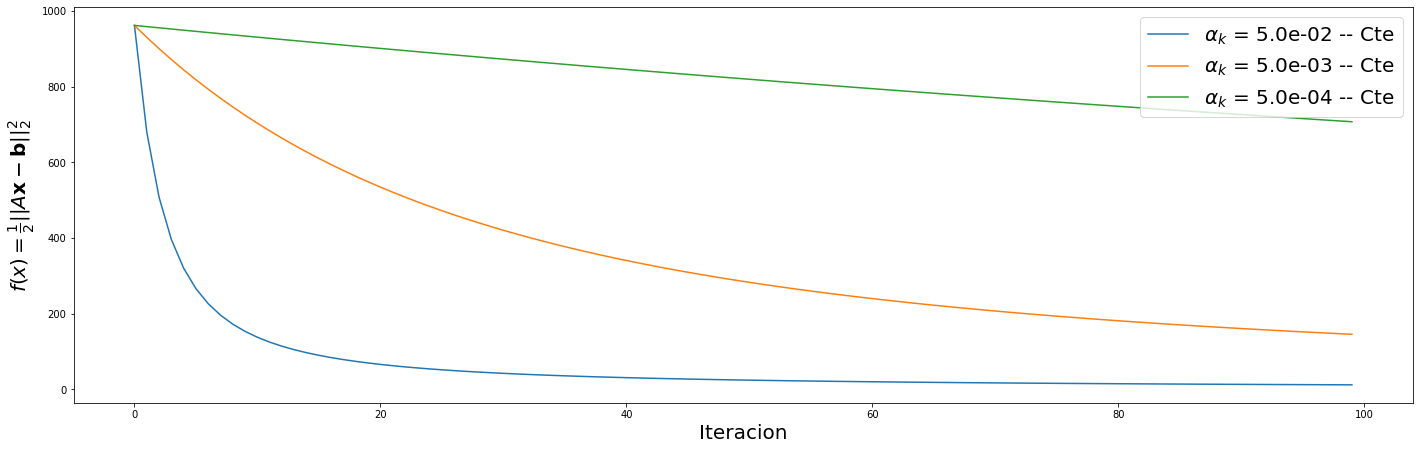

In [10]:
import matplotlib.pylab as PLT
from matplotlib.ticker import MaxNLocator


fig = PLT.figure(figsize=(24, 16))

ax1 = fig.add_subplot(2, 1, 1)

for k in range(len(ssCte)):
    PLT.plot(gdStats[k][:,0], label=r'$\alpha_k$ = {:1.1e} -- {:}'.format(ssCte[k], f2oDef.ss.Cte.name) )

PLT.legend(loc='upper right',fontsize=20)
PLT.ylabel(r'$f(x) = \frac{1}{2} \|\| A \mathbf{x} - \mathbf{b} \|\|_2^2$',fontsize=20)
PLT.xlabel('Iteracion',fontsize=20)



## GD (gradient descent) with adaptive step-size 
#### GD's step-size can be automatically determine. 
* #### Cauchy step-size
* #### Barzilai-Borwein
* #### etc.



In [14]:
ssPolicy = [f2oDef.ss.Cte, 
            f2oDef.ss.BBv2,
            f2oDef.ss.Cauchy]

nIter = 100

x = []
gdStats = []

args.verbose     = True
args.verboseStep = 25

for k in range(len(ssPolicy)):
    
    args.ssPolicy = ssPolicy[k]
    
    if args.ssPolicy is f2oDef.ss.Cte:
       args.ssCte     = ssCte[k]                 # see previous example
    else:
       args.ssCte     = 0.0
    
    sol   = GD(Op, b, nIter, args)
    x.append(sol[0])
    gdStats.append(sol[1])





Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.620e+02	 5.00e-02    7.66e-03    nan
 25	 5.167e+01	 5.00e-02    8.49e-02    1.340e-02
 50	 2.432e+01	 5.00e-02    1.88e-01    5.629e-03
 75	 1.588e+01	 5.00e-02    3.12e-01    3.439e-03
 99	 1.195e+01	 5.00e-02    4.73e-01    2.480e-03


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.620e+02	 2.20e-01    5.15e-03    nan
 25	 1.381e+01	 1.36e-01    2.47e-01    4.779e-02
 50	 8.915e-01	 6.43e-01    4.37e-01    2.068e-03
 75	 2.393e-01	 8.68e-01    6.22e-01    1.084e-03
 99	 3.087e-02	 4.04e-01    8.67e-01    4.351e-03


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 9.620e+02	 2.20e-01    1.33e-02    nan
 25	 9.224e+00	 2.68e-01    1.59e-01    1.350e-02
 50	 4.570e+00	 2.58e-01    2.96e-01    6.165e-03
 75	 3.030e+00	 2.71e-01    4.19e-01    4.081e-03
 99	 2.280e+00	 2.71e-01    5.55e-01    3.035e-03


Text(0.5, 0, 'Time')

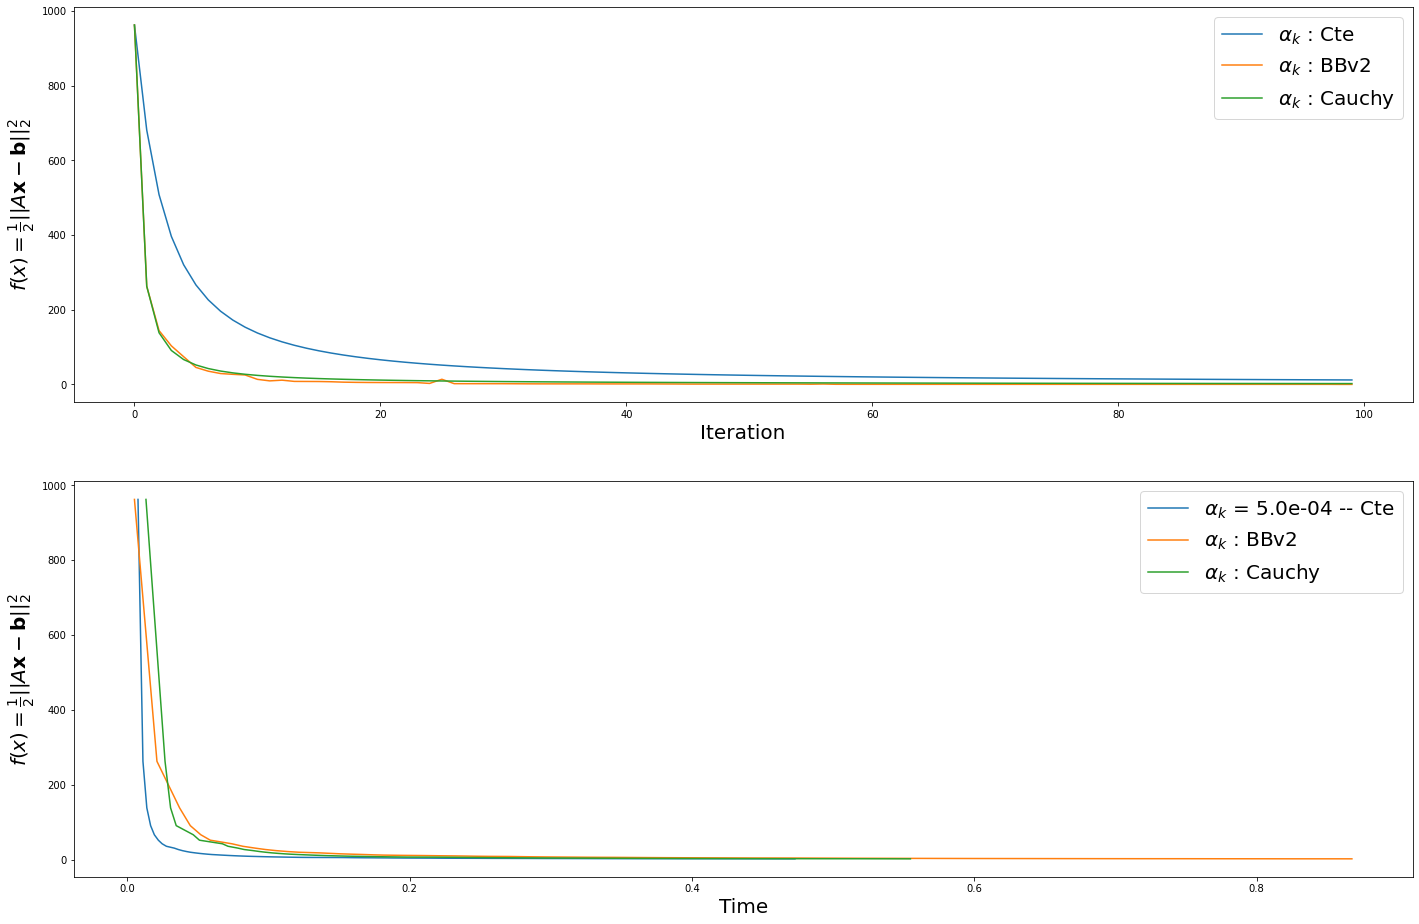

In [18]:

fig = PLT.figure(figsize=(24, 16))


ax = fig.add_subplot(2, 1, 1)

for n in range(len(ssPolicy)):
    if ssPolicy[k] is args.f2oDef.ss.Cte:
       PLT.plot(gdStats[n][:,0], label=r'$\alpha_k$ = {:1.1e} -- {:}'.format(ssCte[k], ssPolicy[n].name) )
    else:
       PLT.plot(gdStats[n][:,0], label=r'$\alpha_k$ : {:}'.format(ssPolicy[n].name) )
     
PLT.legend(loc='upper right',fontsize=20)
PLT.ylabel(r'$f(x) = \frac{1}{2} \|\| A \mathbf{x} - \mathbf{b} \|\|_2^2$',fontsize=20)
PLT.xlabel('Iteration',fontsize=20)


ax = fig.add_subplot(2, 1, 2)

for n in range(len(ssPolicy)):
    if ssPolicy[n] is f2oDef.ss.Cte:
       PLT.plot(gdStats[n][:,2], gdStats[k][:,0], label=r'$\alpha_k$ = {:1.1e} -- {:}'.format(ssCte[k], ssPolicy[n].name) )
    else:
       PLT.plot(gdStats[n][:,2], gdStats[k][:,0], label=r'$\alpha_k$ : {0}'.format(ssPolicy[n].name) )
     
PLT.legend(loc='upper right',fontsize=20)
PLT.ylabel(r'$f(x) = \frac{1}{2} \|\| A \mathbf{x} - \mathbf{b} \|\|_2^2$',fontsize=20)
PLT.xlabel('Time',fontsize=20)

